## Portfolio Optimization Using Clustering.

This project combines unsupervised machine learning (KMeans clustering) and portfolio theory to build more informed investment portfolios. 
First, we group stocks based on their statistical return behavior. 
Then, we apply mean-variance optimization within each cluster to construct efficient portfolios tailored to each group of similarly-behaving assets.
This approach highlights how clustering can enhance diversification and lead to better portfolio construction decisions compared to treating all assets uniformly.

## Required Packages.

You need to install the following packages before running this notebook(Use:pip install):

List-yfinance pandas numpy matplotlib seaborn scikit-learn PyPortfolioOpt

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

We use `datetime` and `timedelta` to define our date range.

- `datetime.now()` returns today's date
- `timedelta(days=...)` lets us go back in time to fetch historical stock data

In [2]:
end= datetime.now()
start=end-timedelta(252*2)

## Downloading Historical Stock Data.

We use `yfinance` to get 2 years of daily stock prices for selected companies.                                                            
The `Close` price is used to calculate daily returns.

In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'JPM', 'V', 'NVDA', 'JNJ']
stock_data = yf.download(tickers, start, end)['Close']
returns= stock_data.pct_change().dropna()

C:\Users\julia\AppData\Local\Temp\ipykernel_18676\805900971.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tickers, start, end)['Close']
[*********************100%***********************]  10 of 10 completed


## Feature Engineering.

We calculate mean return, volatility, skewness, and kurtosis of daily returns.                                                            
These statistical features will be used for clustering.

In [4]:
features = pd.DataFrame()
features['mean_return'] = returns.mean()
features['volatility'] = returns.std()
features['skew'] = returns.skew()
features['kurtosis'] = returns.kurtosis()

## Unsupervised Clustering with KMeans.

We use `KMeans` to group stocks into 3 clusters based on their return distributions.                                                        
This helps segment assets by statistical behavior.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

X = StandardScaler().fit_transform(features)  # Normalize for clustering
kmeans = KMeans(n_clusters=3, random_state=0)
features['cluster'] = kmeans.fit_predict(X)

## Visualization of Clusters.

A scatter plot shows how stocks are grouped based on their mean return and volatility.                                                    
Each color represents a different cluster.

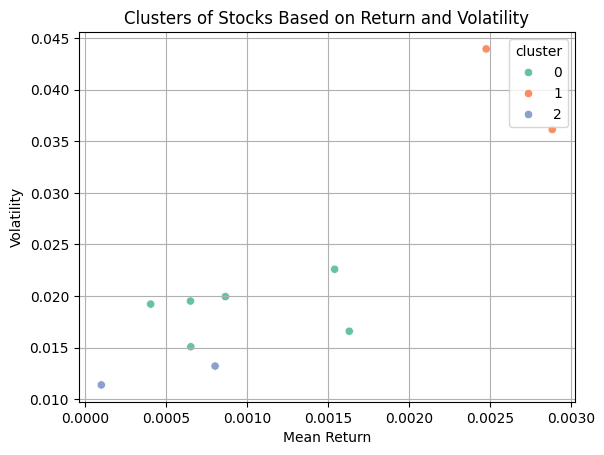

In [6]:
sns.scatterplot(data=features, x='mean_return', y='volatility', hue='cluster', palette='Set2')
plt.title("Clusters of Stocks Based on Return and Volatility")
plt.xlabel("Mean Return")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

## Portfolio optimization in each cluster.

We use `PyPortfolioOpt` to find the optimal portfolio (maximum Sharpe ratio) for each cluster of assets based on expected return and risk.

In [7]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return

for i in range(3):
    group = features[features['cluster'] == i].index
    price_data = stock_data[group]

    mu = mean_historical_return(price_data)
    S = CovarianceShrinkage(price_data).ledoit_wolf()

    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    print(f"Cluster {i} Optimal Weights:\n", cleaned_weights)


Cluster 0 Optimal Weights:
 OrderedDict({'AAPL': 0.0, 'AMZN': 0.0, 'GOOGL': 0.0, 'JPM': 0.78197, 'META': 0.21803, 'MSFT': 0.0})
Cluster 1 Optimal Weights:
 OrderedDict({'NVDA': 0.83194, 'TSLA': 0.16806})
Cluster 2 Optimal Weights:
 OrderedDict({'JNJ': 0.0, 'V': 1.0})


## Interpretation

Each cluster gives us an optimized set of asset weights.                                                                              These optimized portfolios represent the most efficient allocation within each asset cluster, based on historical return and risk metrics.                                                                                                                                 
Recommendations can therefore be made based on aspects such as investor risk appetite.